# EDNet Theta–Feature visualization




In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# 노트북/데스크탑 어디서든 동작: Q2_code 폴더 자동 감지
_cwd = Path.cwd()
if (_cwd / "theta_feature_vis.ipynb").exists():
    Q2_CODE = _cwd
elif (_cwd / "Q2_code" / "theta_feature_vis.ipynb").exists():
    Q2_CODE = _cwd / "Q2_code"
else:
    Q2_CODE = _cwd
OUT = Q2_CODE / "outputs"
PLOTS = OUT / "plots"  # 기존 SVG와는 무관, 여기서는 노트북 내 inline 플롯만 사용

# outputs/ 또는 Q2_code 바로 아래, 파일명 두 가지 모두 지원
_candidates = [
    OUT / "student_features_mid.csv",
    OUT / "student_features.csv",
    Q2_CODE / "student_features_mid.csv",
    Q2_CODE / "student_features.csv",
]
student_features_path = next((p for p in _candidates if p.exists()), _candidates[0])
student_features_path

WindowsPath('/Users/parksungha/Desktop/DSL/EDA/Q2_code/outputs/student_features_mid.csv')

In [4]:
df = pd.read_csv(student_features_path)
df = df.replace([float("inf"), float("-inf")], pd.NA)
df = df.dropna(subset=["theta"]).copy()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '\\Users\\parksungha\\Desktop\\DSL\\EDA\\Q2_code\\outputs\\student_features_mid.csv'

In [ ]:
feature_cols = [
    "accuracy",
    "avg_response_time_ms",
    "n_problems",
    "abandon_rate",
    "time_on_task_total_ms",
    "consecutive_days",
    "active_days",
    "erase_rate",
    "undo_rate",
    "answer_change_rate",
    "explanation_adoption_rate",
    "explanation_after_wrong_rate",
    "source_entropy",
    "adaptive_offer",
    "media_play_rate",
    "accuracy_per_time",
    "accuracy_per_problem",
]

# 실제 df에 존재하는 컬럼만 필터링
feature_cols = [c for c in feature_cols if c in df.columns]
feature_cols

['accuracy',
 'avg_response_time_ms',
 'n_problems',
 'abandon_rate',
 'time_on_task_total_ms',
 'consecutive_days',
 'active_days',
 'erase_rate',
 'undo_rate',
 'answer_change_rate',
 'explanation_adoption_rate',
 'explanation_after_wrong_rate',
 'explanation_time_per_problem_ms',
 'source_entropy',
 'adaptive_offer',
 'media_play_rate',
 'accuracy_per_time',
 'accuracy_per_problem']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 선택된 feature들을 사용해 4개 군집 클러스터링
# 결측값이 있는 행은 일단 제외하고 진행
X = df[feature_cols].dropna().copy()

# 스케일링 (feature 스케일 차이 보정)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means로 4개 군집
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

# 원본 df에 클러스터 라벨 추가 (인덱스 정렬 유지)
df.loc[X.index, "cluster_4"] = cluster_labels

# 각 군집별 학생 수와 평균 feature/theta 요약
cluster_counts = df["cluster_4"].value_counts().sort_index()
cluster_summary = df.groupby("cluster_4")[feature_cols + ["theta"]].mean().round(3)

print("Cluster counts:")
print(cluster_counts)
print("\nCluster feature/theta means:")
cluster_summary

## 1. theta–feature Spearman


In [21]:
corr_rows = []
for feat in feature_cols:
    tmp = df[["theta", feat]].dropna()
    if len(tmp) < 50:
        continue
    # Use DataFrame.corr (type checker treats column as ndarray)
    sp = tmp[["theta", feat]].corr(method="spearman").iloc[0, 1]
    pr = tmp[["theta", feat]].corr(method="pearson").iloc[0, 1]
    corr_rows.append((feat, float(sp), float(pr), len(tmp)))

corr_df = (
    pd.DataFrame(corr_rows, columns=["feature", "spearman", "pearson", "n"])
    .sort_values("spearman", ascending=False)
)
corr_df.head(12)

/Users/parksungha/Desktop/DSL/EDA/Q2_code/.venv/lib/python3.14/site-packages/pandas/core/nanops.py:1661: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Users/parksungha/Desktop/DSL/EDA/Q2_code/.venv/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/parksungha/Desktop/DSL/EDA/Q2_code/.venv/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,feature,spearman,pearson,n
0,accuracy,0.780998,0.593152,23477
2,n_problems,0.741546,0.647012,23477
4,time_on_task_total_ms,0.610933,0.550002,23002
6,active_days,0.567563,0.530994,23477
5,consecutive_days,0.527244,0.497193,23477
16,accuracy_per_time,0.436311,0.276144,22970
14,adaptive_offer,0.385772,0.170166,23002
11,explanation_after_wrong_rate,0.231566,0.084195,23466
10,explanation_adoption_rate,0.114015,0.027385,23477
13,source_entropy,0.112584,0.094560,23002


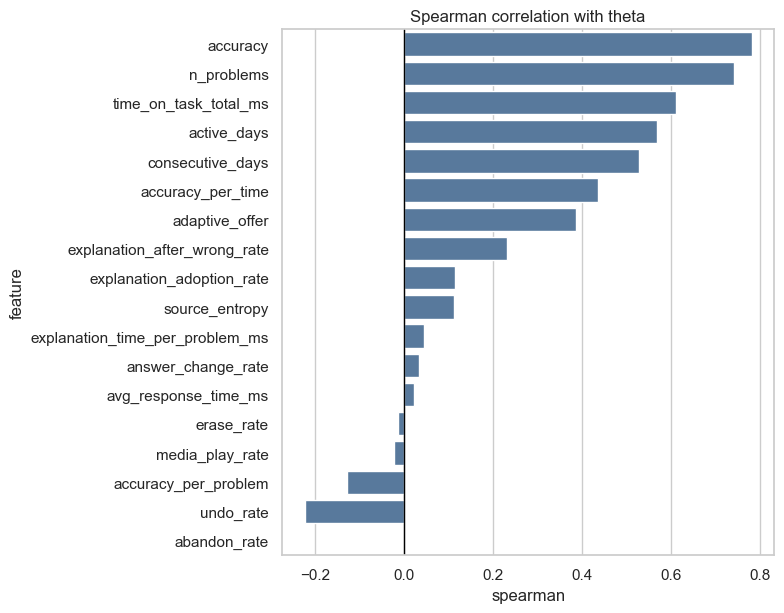

In [22]:
plt.figure(figsize=(8, max(4, 0.35 * len(corr_df))))
sns.barplot(data=corr_df, y="feature", x="spearman", color="#4C78A8")
plt.axvline(0, color="black", linewidth=1)
plt.title("Spearman correlation with theta")
plt.tight_layout()
plt.show()

In [23]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# theta–feature 상관 + p-value 테이블 계산 (경로: 노트북 위치 기준 자동 감지)
_cwd = Path.cwd()
if (_cwd / "theta_feature_vis.ipynb").exists():
    Q2_CODE = _cwd
elif (_cwd / "Q2_code" / "theta_feature_vis.ipynb").exists():
    Q2_CODE = _cwd / "Q2_code"
else:
    Q2_CODE = _cwd
OUT = Q2_CODE / "outputs"
_candidates = [
    OUT / "student_features_mid.csv",
    OUT / "student_features.csv",
    Q2_CODE / "student_features_mid.csv",
    Q2_CODE / "student_features.csv",
]
sf_path = next((p for p in _candidates if p.exists()), _candidates[0])
df_p = pd.read_csv(sf_path)
df_p = df_p.replace([np.inf, -np.inf], np.nan).dropna(subset=["theta"])  # NaN/inf 정리

feature_cols = [
    "accuracy",
    "avg_response_time_ms",
    "n_problems",
    "abandon_rate",
    "time_on_task_total_ms",
    "consecutive_days",
    "active_days",
    "erase_rate",
    "undo_rate",
    "answer_change_rate",
    "explanation_adoption_rate",
    "explanation_after_wrong_rate",
    "explanation_time_per_problem_ms",
    "source_entropy",
    "adaptive_offer",
    "media_play_rate",
    "accuracy_per_time",
    "accuracy_per_problem",
]
feature_cols = [c for c in feature_cols if c in df_p.columns]

rows = []
for feat in feature_cols:
    tmp = df_p[["theta", feat]].dropna()
    if len(tmp) < 10:
        continue
    pr, pr_p = pearsonr(tmp["theta"], tmp[feat])
    sp, sp_p = spearmanr(tmp["theta"], tmp[feat])
    rows.append(
        {
            "feature": feat,
            "n": len(tmp),
            "pearson": pr,
            "pearson_p": pr_p,
            "spearman": sp,
            "spearman_p": sp_p,
        }
    )

corr_p_df = (
    pd.DataFrame(rows)
    .sort_values("spearman", ascending=False)
    .reset_index(drop=True)
)
corr_p_df

/var/folders/rt/jlm3wv654t701xkpm__lwpz40000gn/T/ipykernel_90474/2326121157.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr, pr_p = pearsonr(tmp["theta"], tmp[feat])
/var/folders/rt/jlm3wv654t701xkpm__lwpz40000gn/T/ipykernel_90474/2326121157.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp, sp_p = spearmanr(tmp["theta"], tmp[feat])


,feature,n,pearson,pearson_p,spearman,spearman_p
0,accuracy,23477,0.593152,0.000000e+00,0.780998,0.000000e+00
1,n_problems,23477,0.647012,0.000000e+00,0.741546,0.000000e+00
2,time_on_task_total_ms,23002,0.550002,0.000000e+00,0.610933,0.000000e+00
3,active_days,23477,0.530994,0.000000e+00,0.567563,0.000000e+00
4,consecutive_days,23477,0.497193,0.000000e+00,0.527244,0.000000e+00
5,accuracy_per_time,22970,0.276144,0.000000e+00,0.436311,0.000000e+00
6,adaptive_offer,23002,0.170166,5.430857e-149,0.385772,0.000000e+00
7,explanation_after_wrong_rate,23466,0.084195,3.479355e-38,0.231566,3.439037e-283
8,explanation_adoption_rate,23477,0.027385,2.710171e-05,0.114015,9.104524e-69
9,source_entropy,23002,0.094560,7.669018e-47,0.112584,9.089462e-66


## 2. **IQR** theta_q


In [24]:
df["theta_q"] = pd.qcut(df["theta"], q=4, labels=["Q1(low)", "Q2", "Q3", "Q4(high)"])
df[["theta", "theta_q"]].head()

,theta,theta_q
0,0.187306,Q4(high)
1,-0.031337,Q3
2,-0.255845,Q1(low)
3,0.219244,Q4(high)
4,-0.084564,Q3


## 3. 개별 feature 시각화

- theta vs feature 산점도 + 회귀선
- theta 사분위(theta_q)별 feature 박스플롯



In [25]:
features_to_plot = [
    "accuracy",
    "avg_response_time_ms",
    "n_problems",
    "abandon_rate",
    "time_on_task_total_ms",
    "consecutive_days",
    "active_days",
    "erase_rate",
    "undo_rate",
    "answer_change_rate",
    "explanation_adoption_rate",
    "explanation_after_wrong_rate",
    "explanation_time_per_problem_ms",
    "source_entropy",
    "adaptive_offer",
    "media_play_rate",
    "accuracy_per_time",
    "accuracy_per_problem",
]
features_to_plot = [f for f in features_to_plot if f in df.columns]
features_to_plot

['accuracy',
 'avg_response_time_ms',
 'n_problems',
 'abandon_rate',
 'time_on_task_total_ms',
 'consecutive_days',
 'active_days',
 'erase_rate',
 'undo_rate',
 'answer_change_rate',
 'explanation_adoption_rate',
 'explanation_after_wrong_rate',
 'explanation_time_per_problem_ms',
 'source_entropy',
 'adaptive_offer',
 'media_play_rate',
 'accuracy_per_time',
 'accuracy_per_problem']

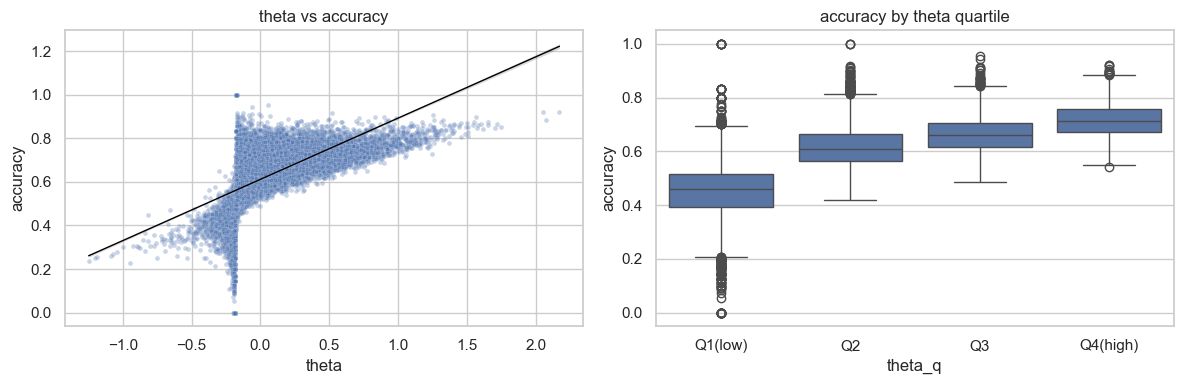

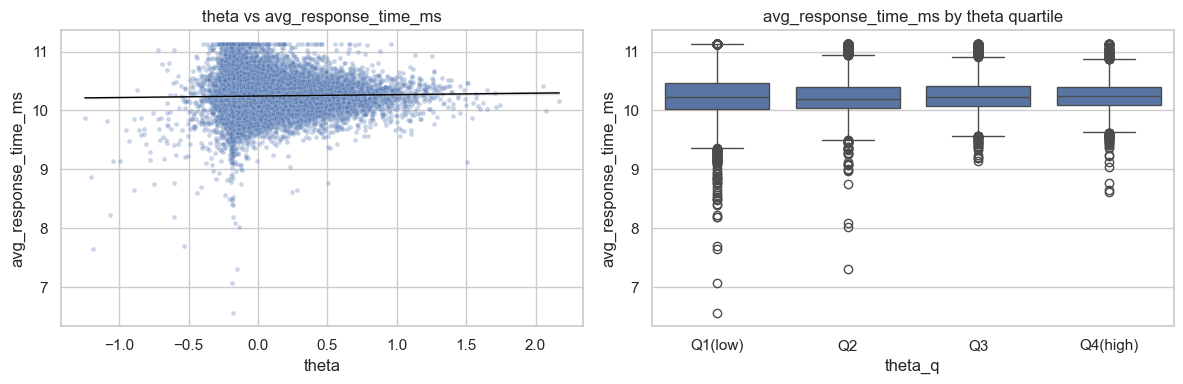

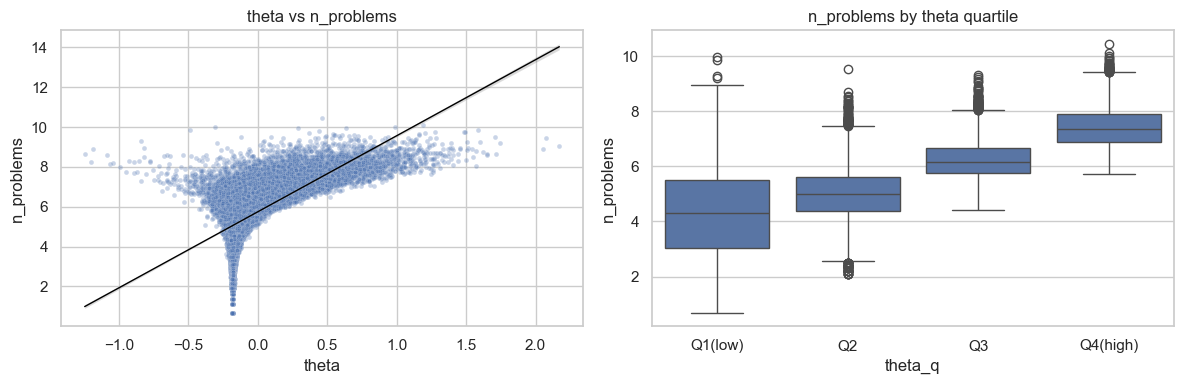

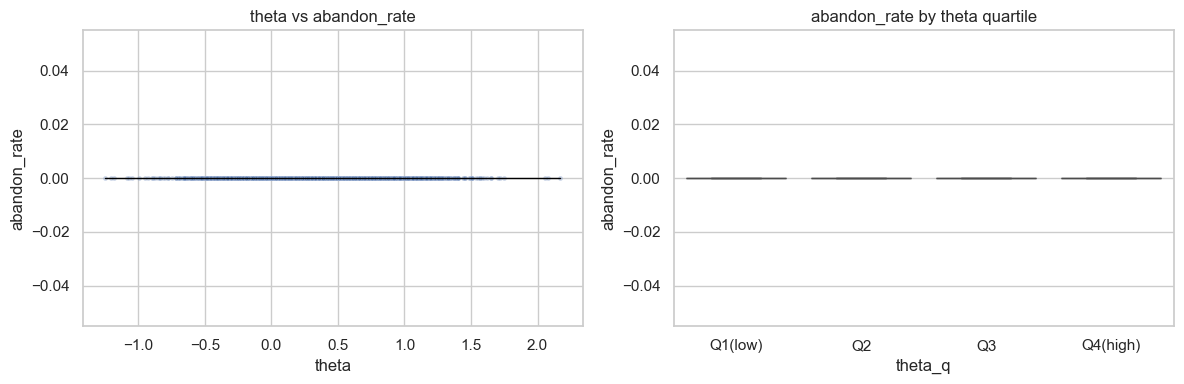

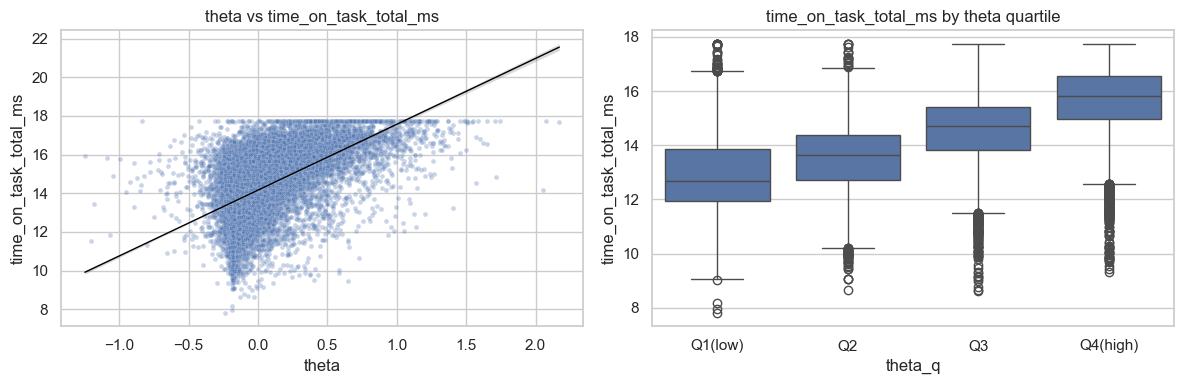

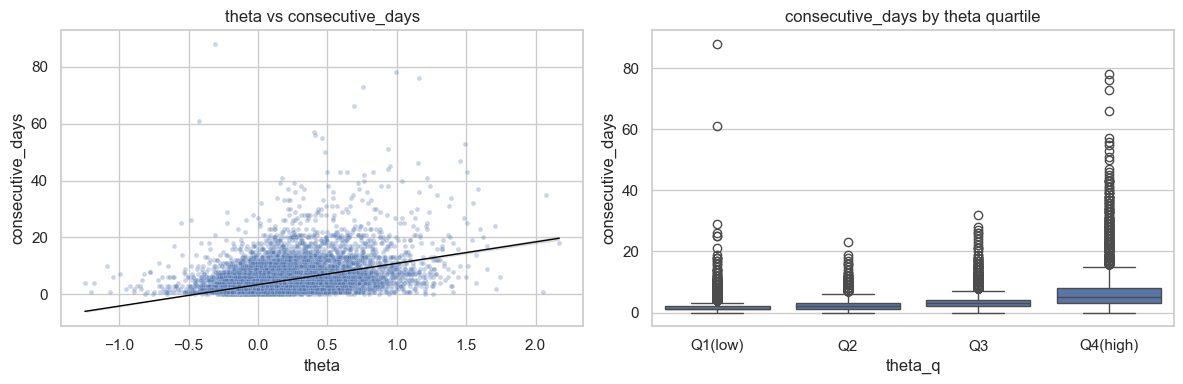

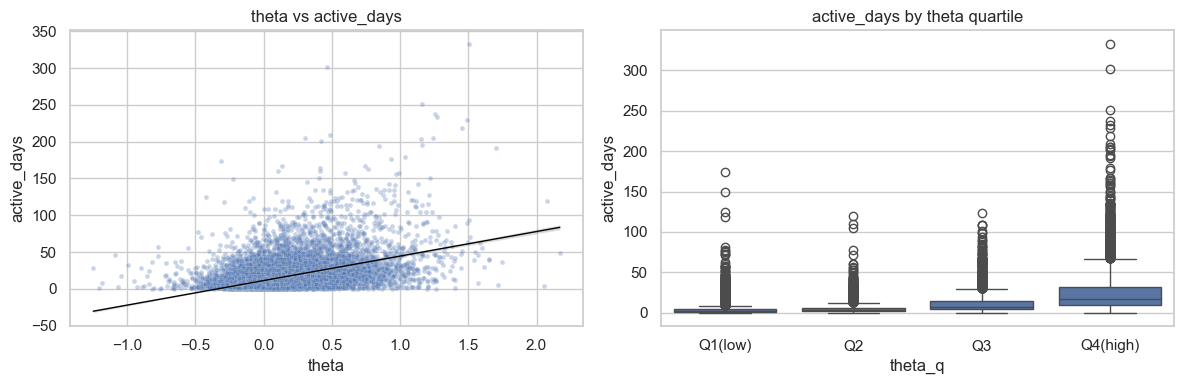

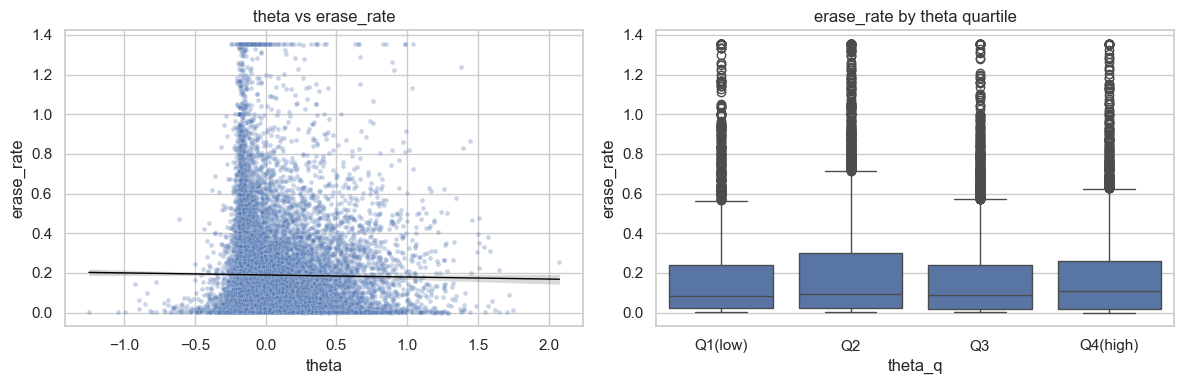

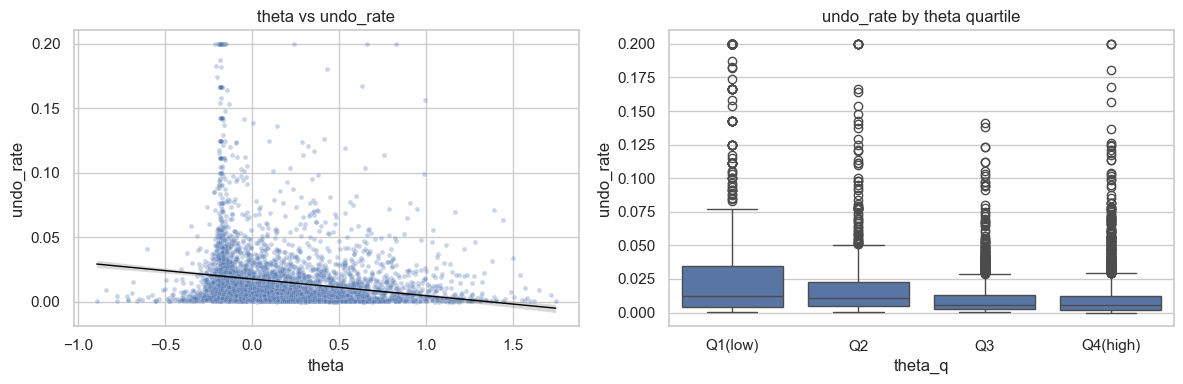

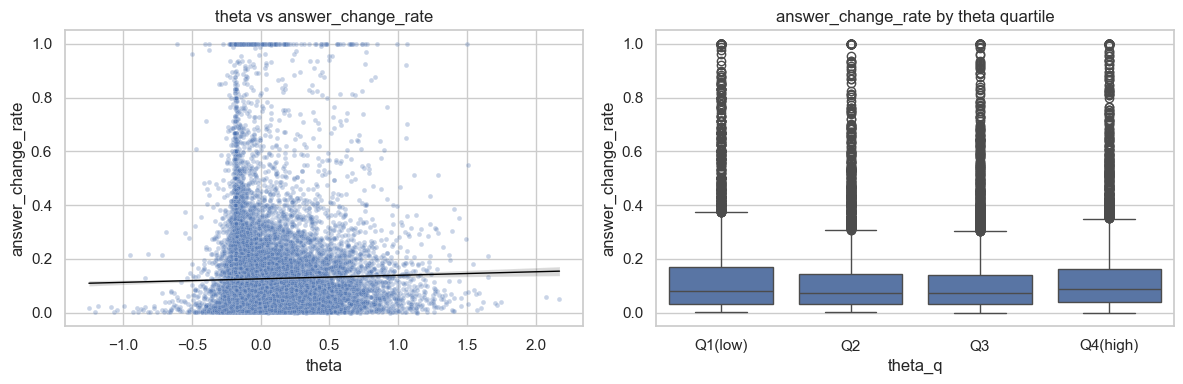

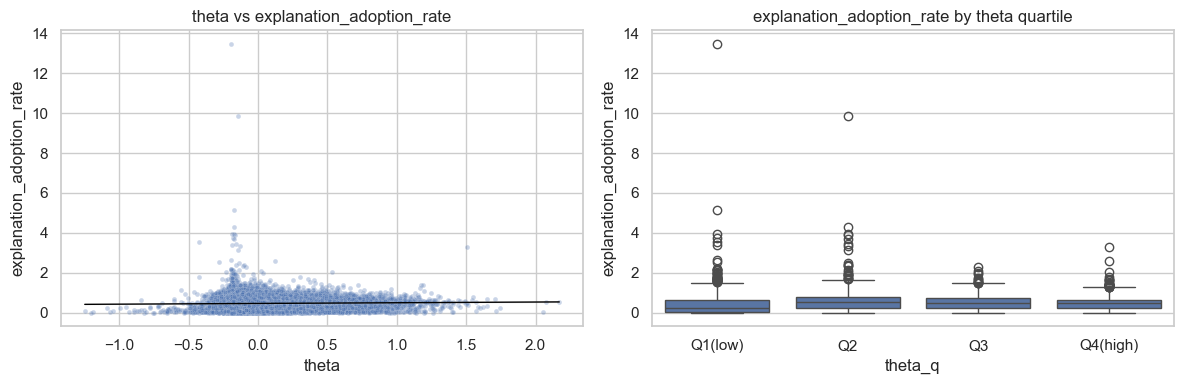

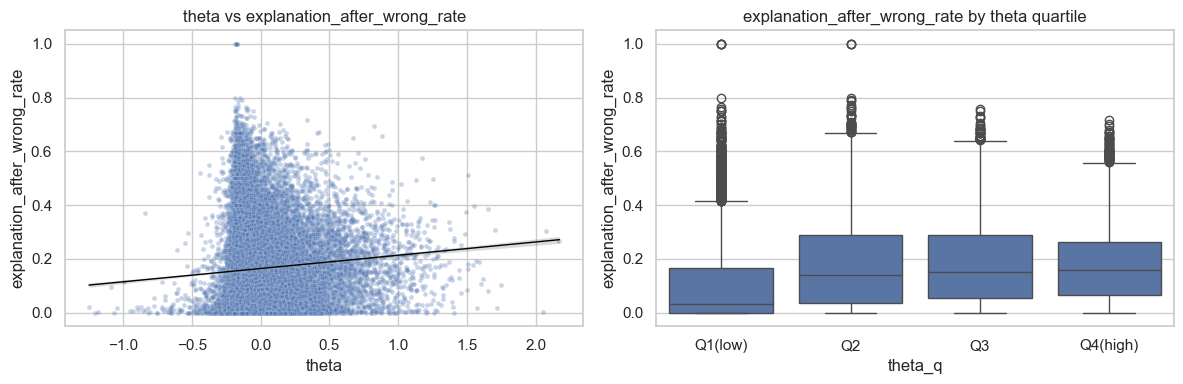

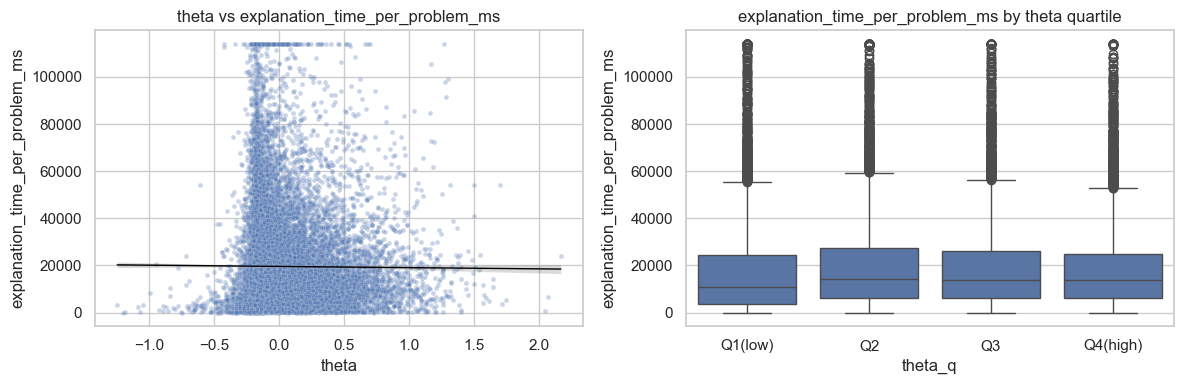

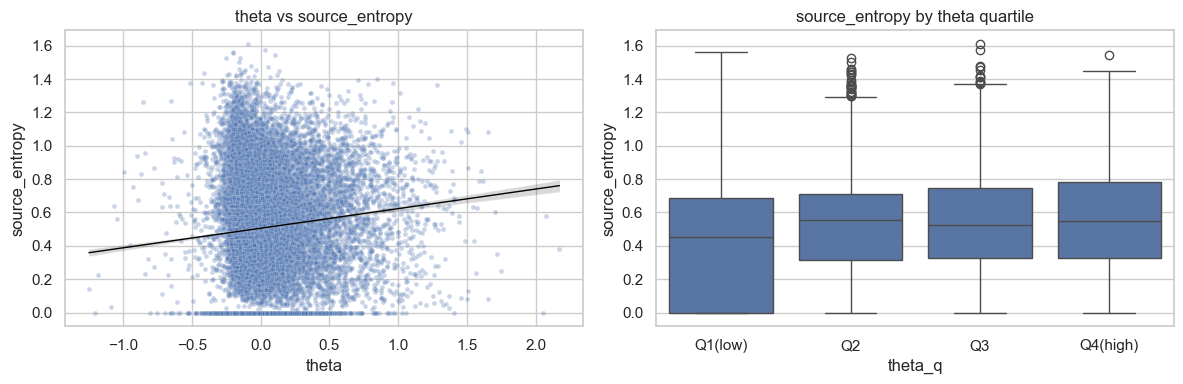

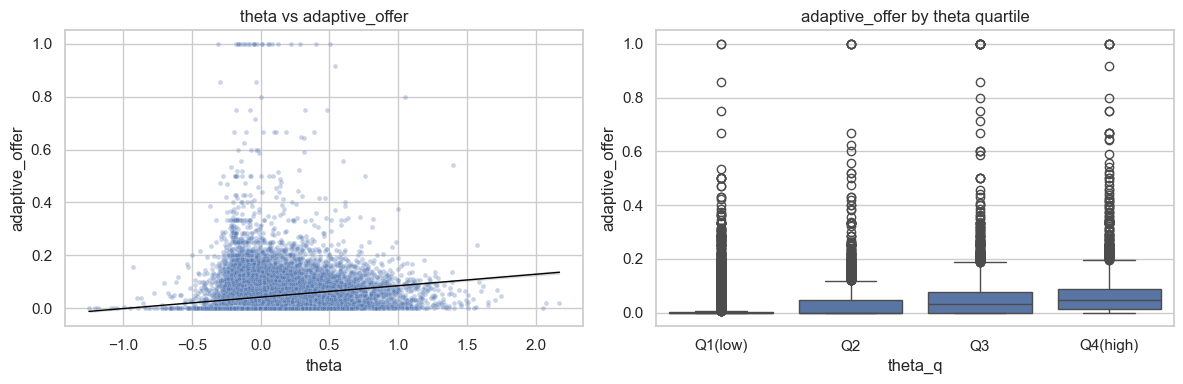

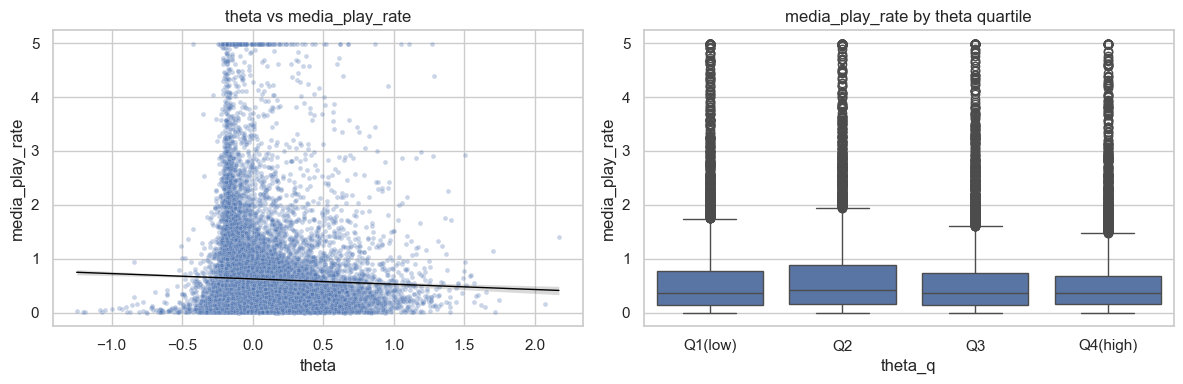

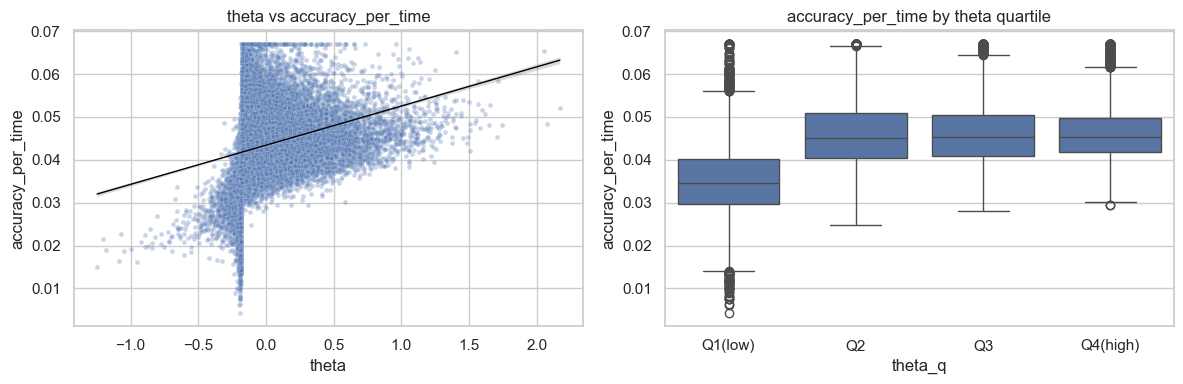

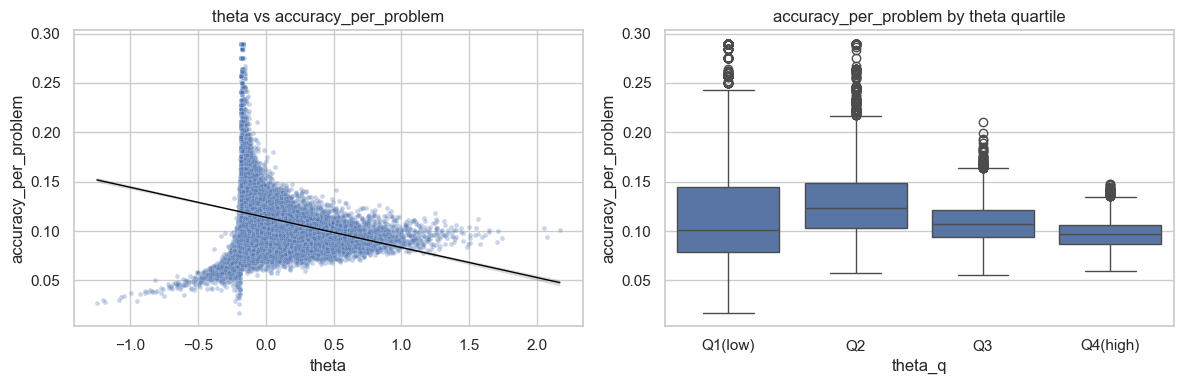

In [26]:
for feat in features_to_plot:
    tmp = df[["theta", "theta_q", feat]].dropna()
    if tmp.empty:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 산점도 + 회귀선
    sns.scatterplot(data=tmp, x="theta", y=feat, s=12, alpha=0.3, ax=axes[0])
    sns.regplot(data=tmp, x="theta", y=feat, scatter=False, color="black", line_kws={"linewidth": 1}, ax=axes[0])
    axes[0].set_title(f"theta vs {feat}")

    # 사분위 박스플롯
    sns.boxplot(data=tmp, x="theta_q", y=feat, ax=axes[1])
    axes[1].set_title(f"{feat} by theta quartile")

    plt.tight_layout()
    plt.show()